# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-02-11.parquet"

DOCUMENT_SOURCES = {
    "fedlex",
    "openparldata",
}
LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    "openparldata",
    "organisation_rule",
    "manual",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    "DRAFT",
    None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.lib import data_access, data_transformations, embeddings, plotting, stratified_group_split

In [4]:
dotenv.load_dotenv()

True

In [5]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document topics")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_sources", sorted(DOCUMENT_SOURCES))
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: whimsical-carp-330


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/02/11 14:48:48 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources=DOCUMENT_SOURCES,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
21,22,2,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]",DRAFT,de,Vernehmlassungsvorlage,38,Bundesamt für Kommunikation,ch,2025-01-27 11:30:14,fedlex,manual,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...
42,43,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage EnEV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
51,52,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage RPV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,1 \nRaumplanungsverordnung \n \nVernehmlassung...
54,55,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage NIV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52370,54010,4787,2024-06-25,2024-09-25,Teilrevision des Einführungsgesetzes zum Bunde...,Die gesetzlichen Grundlagen rund um die Pflege...,https://www.nw.ch/_doc/406588,https://www.demokratis.ch/vernehmlassung/a7ux8tat,"[health, insurance, public_finance]",NaN,de,03_Bericht und Antrag an Landrat,154,Regierungsrat des Kantons Nidwalden,nw,2025-02-10 14:12:04,openparldata,manual,\n \n \n \n \nKANTON \nNIDWALDEN \n GESUNDHEI...
52371,54011,4787,2024-06-25,2024-09-25,Teilrevision des Einführungsgesetzes zum Bunde...,Die gesetzlichen Grundlagen rund um die Pflege...,https://www.nw.ch/_doc/406591,https://www.demokratis.ch/vernehmlassung/a7ux8tat,"[health, insurance, public_finance]",NaN,de,04_Bericht Ergebnis der Vernehmlassung,154,Regierungsrat des Kantons Nidwalden,nw,2025-02-10 14:12:04,openparldata,manual,\n \n \n \n \nKANTON \nNIDWALDEN \n REGIERUNG...
52372,54012,4787,2024-06-25,2024-09-25,Teilrevision des Einführungsgesetzes zum Bunde...,Die gesetzlichen Grundlagen rund um die Pflege...,https://www.nw.ch/_doc/406594,https://www.demokratis.ch/vernehmlassung/a7ux8tat,"[health, insurance, public_finance]",NaN,de,05_NG 742.112 Information an Landrat,154,Regierungsrat des Kantons Nidwalden,nw,2025-02-10 14:12:04,openparldata,manual,Information an Landrat (17. Dezember 2024)\nVe...
52373,54013,4787,2024-06-25,2024-09-25,Teilrevision des Einführungsgesetzes zum Bunde...,Die gesetzlichen Grundlagen rund um die Pflege...,https://www.nw.ch/_doc/406597,https://www.demokratis.ch/vernehmlassung/a7ux8tat,"[health, insurance, public_finance]",

In [9]:
df_docs["document_type"].value_counts(dropna=False)

document_type
NaN               9779
DRAFT             2938
DECISION             0
FINAL_REPORT         0
LETTER               0
LINK                 0
OPINION              0
RECIPIENT_LIST       0
REPORT               0
RESPONSE_FORM        0
SURVEY               0
SYNOPTIC_TABLE       0
VARIOUS_TEXT         0
Name: count, dtype: int64

## Create synthetic "documents" from consultation titles, descriptions, org names...

In [10]:
df_consultations_synthetic = data_transformations.create_synthetic_documents_from_consultations(df_docs)
df_consultations_synthetic

,consultation_id,consultation_start_date,consultation_end_date,consultation_url,consultation_topics,consultation_topics_label_source,consultation_reviewed_at,organisation_id,political_body,document_id,document_source,document_source_url,document_language,document_title,document_type,document_content_plain,organisation_name,consultation_title,consultation_description
0,1,2021-10-01,2022-01-17,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",manual,2024-11-04 15:11:24,41,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Zoll und Grenzsicherheit,<synthetic>,<synthetic>,<synthetic>
1,2,2021-12-03,2022-03-18,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]",manual,2025-01-27 11:30:14,38,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Kommunikation,<synthetic>,<synthetic>,<synthetic>
2,3,2021-10-11,2022-01-25,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],organisation_rule,NaT,44,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Energie,<synthetic>,<synthetic>,<synthetic>
3,4,2021-11-24,2022-03-10,https://www.demokratis.ch/vernehmlassung/y9vpep78,[energy],organisation_rule,NaT,44,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Energie,<synthetic>,<synthetic>,<synthetic>
4,5,2021-12-10,2022-03-24,https://www.demokratis.ch/vernehmlassung/x7985bkz,"[economics, public_finance, science]",manual,2025-01-07 13:08:21,90,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Staatssekretariat für Wirtschaft,<synthetic>,<synthetic>,<synthetic>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,5023,2025-01-24,2025-03-28,https://www.demokratis.ch/vernehmlassung/uc77u6c4,"[administration, law]",manual,2025-01-27 13:46:36,143,ar,-1,openparldata,https://ar.ch/fileadmin/user_upload/Kantonskan...,de,None,consultation_description,Der Regierungsrat hat die Vorlage für eine Tei...,<synthetic>,<synthetic>,<synthetic>
11951,5025,2025-01-27,2025-04-30,https://www.demokratis.ch/vernehmlassung/tk89g848,"[administration, communications, it]",manual,2025-01-30 14:38:59,155,ow,-1,openparldata,https://www.ow.ch/_doc/405397,de,None,consultation_description,Der Regierungsrat hat am 21. Januar 2025 den E...,<synthetic>,<synthetic>,<synthetic>
11952,5026,2025-01-30,2025-05-08,https://www.demokratis.ch/vernehmlassung/bxcmhpvu,"[health, insurance]",manual,2025-02-03 15:03:00,86,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,consultation_description,Mit dieser Vorlage möchte die Kommission für s...,<synthetic>,<synthetic>,<synthetic>
11953,5029,2025-02-03,2025-04-30,https://www.demokratis.ch/vernehmlassung/nr976f57,"[public_finance, transportation]",manual,2025-02-10 14:22:25,150,gr,-1,openparldata,https://www.gr.ch/DE/publikationen/vernehmlass...,de,None,consultation_description,Die Regierung hat die Totalrevision des Einfüh...,<synthetic>,<synthetic>,<synthetic>


## Create the input dataframe

In [11]:
df_input, topic_columns = data_transformations.create_input_dataframe(
    df_docs,
    df_consultations_synthetic,
)
df_input

Dropping 1777 documents with empty text.


,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,...,0,0,0,0,0,1,0,0,0,0
1,22,2,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]",DRAFT,...,0,0,0,0,0,1,0,0,0,0
2,43,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
3,52,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
4,55,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24667,-1,5023,2025-01-24,2025-03-28,<synthetic>,<synthetic>,https://ar.ch/fileadmin/user_upload/Kantonskan...,https://www.demokratis.ch/vernehmlassung/uc77u6c4,"[administration, law]",consultation_description,...,0,0,0,0,0,0,0,0,0,0
24668,-1,5025,2025-01-27,2025-04-30,<synthetic>,<synthetic>,https://www.ow.ch/_doc/405397,https://www.demokratis.ch/vernehmlassung/tk89g848,"[administration, communications, it]",consultation_description,...,0,0,0,0,0,0,0,0,0,0
24669,-1,5026,2025-01-30,2025-05-08,<synthetic>,<synthetic>,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/bxcmhpvu,"[health, insurance]",consultation_description,...,0,0,0,0,0,0,0,0,0,0
24670,-1,5029,2025-02-03,2025-04-30,<synthetic>,<synthetic>,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/nr976f57,"[public_finance, transportation]",consultation_description,...,0,0,0,1,0,0,0,0,0,1


## Drop underrepresented topics

In [12]:
df_input, topic_columns = data_transformations.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_media               12
topic_political_system    38
dtype: int64
Dropping these documents without any label: 15


In [13]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_id"].nunique())
print("\ndf_input size (documents):", df_input.shape[0])
print("df_input size (consultations):", df_input["consultation_id"].nunique())

Original number of documents: 12717
Original number of consultations: 3985

df_input size (documents): 22880
df_input size (consultations): 3982


## Splits

### Set aside a test set

In [14]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_id"]))

In [15]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (20511, 43)
Test: (2369, 43)


In [16]:
assert not set(df_input_train["consultation_id"]) & set(
    df_input_test["consultation_id"]
), "No leakage between train and test sets"

In [17]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

2369

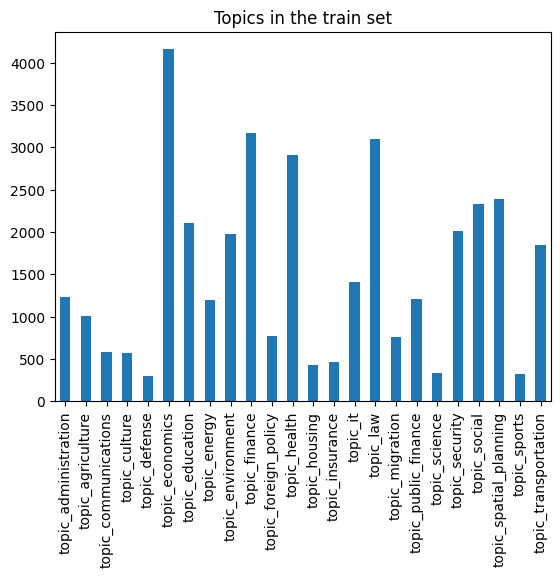

In [18]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

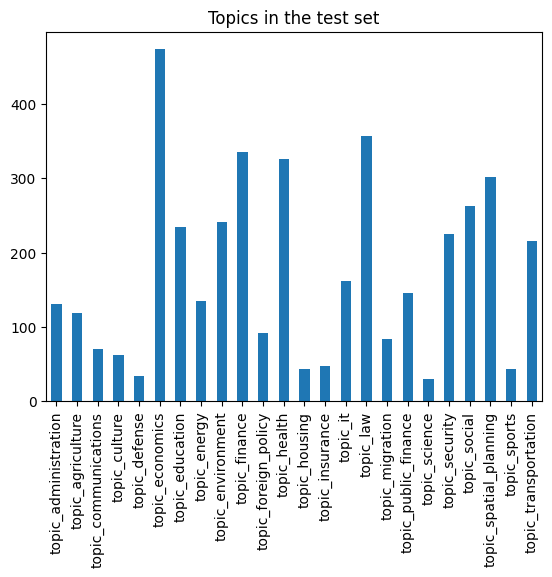

In [19]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

### Prepare a cross-validation splitter

In [20]:
cv_splitter = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [21]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 2369/2369 [00:03<00:00, 764.69it/s]


## Embed

In [22]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=20510, new=0): 100%|██████████| 20511/20511 [00:10<00:00, 2031.83it/s]


(20511, 3072)


Embedding (cached=2368, new=0): 100%|██████████| 2369/2369 [00:01<00:00, 1893.79it/s]


(2369, 3072)


# Classification

In [23]:
X_train = embeddings_train
X_test = embeddings_test

y_train = df_input_train[topic_columns]
y_test = df_input_test[topic_columns]

groups_train = df_input_train["consultation_id"]
groups_test = df_input_test["consultation_id"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (20511, 3072) (20511, 24)
Test (2369, 3072) (2369, 24)


In [24]:
classifier = make_pipeline(
    StandardScaler(),
    # PCA(n_components=200, random_state=RANDOM_STATE),
    MultiOutputClassifier(
        LogisticRegression(max_iter=1000),
    ),
)

classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [25]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])
mlflow.log_param(
    "classifier",
    classifier.named_steps["multioutputclassifier"].estimator.__class__.__name__,
)

'LogisticRegression'

In [26]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_samples",
    "recall": "recall_samples",
    "f1": "f1_samples",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    groups=groups_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'fit_time': array([149.10544395, 179.98759508, 161.122895  , 155.4378612 ,
        155.64057899]),
 'score_time': array([0.19490314, 0.24626899, 0.20984983, 0.19483685, 0.19519186]),
 'test_precision': array([0.5711081 , 0.55987216, 0.57078629, 0.57515941, 0.57178388]),
 'test_recall': array([0.55997785, 0.58254419, 0.57048765, 0.57564164, 0.56569976]),
 'test_f1': array([0.53294764, 0.5370857 , 0.53553896, 0.54006456, 0.53500406]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [27]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.5697 (+/- 0.0052)
Recall:    0.5709 (+/- 0.0078)
F1:        0.5361 (+/- 0.0024)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

Split the training set into 'CV training' and 'CV testing' sets so we still don't have to touch our real test set.

In [28]:
cv_test_splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train, cv_test = stratified_group_split.one_simple_split(
    splitter,
    X=X_train,
    y=y_train,
    groups=groups_train,
)

print("CV train:", cv_train.shapes)
print("CV test:", cv_test.shapes)

CV train: ((18479, 3072), (18479, 24))
CV test: ((2032, 3072), (2032, 24))


2025/02/11 15:03:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/02/11 15:06:16 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3. None expected <= 2.
2025/02/11 15:06:16 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3. None expected <= 2.
2025/02/11 15:06:17 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/02/11 15:06:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


docs: ground truth (2032, 24)
docs: predictions (2032, 24)
consultations: ground truth (350, 24)
consultations: predictions (350, 24)


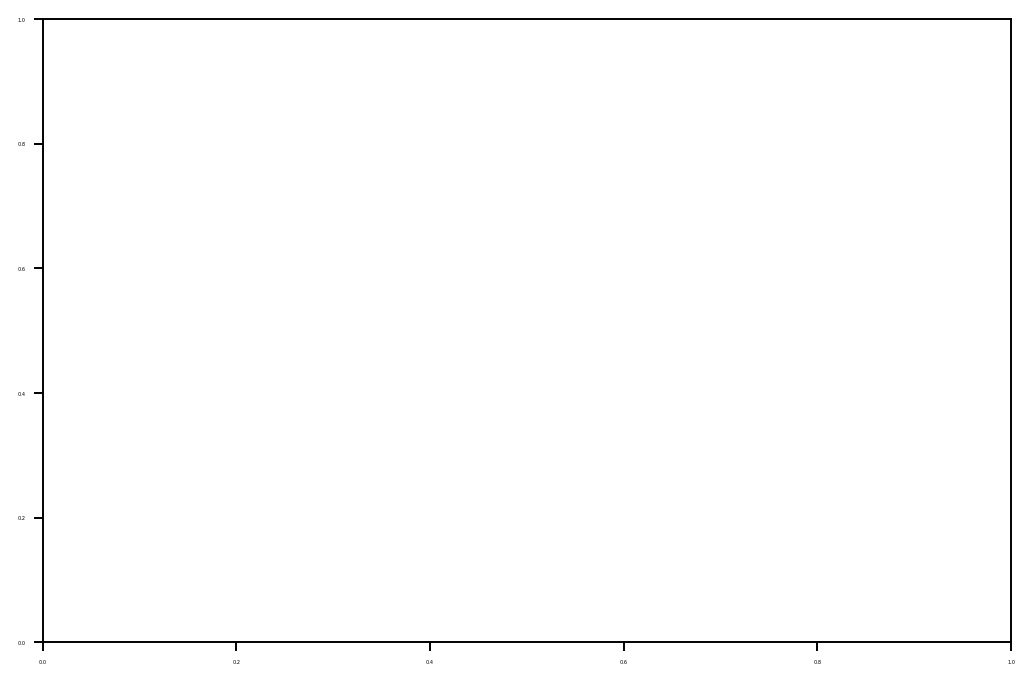

In [29]:
# Train the classifier on the CV train set - documents
classifier.fit(cv_train.X, cv_train.y)
# Get our ground truth - documents
cv_test_ground_truth_docs = cv_test.y
# Predict on the CV test set - documents
cv_test_predictions_docs = classifier.predict(cv_test.X)
assert isinstance(cv_test_predictions_docs, np.ndarray)

# Convert our per-document ground truth to consultations
cv_test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_ground_truth_docs,
)
# Convert our per-document predictions to consultations
cv_test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_predictions_docs,
)

print("docs: ground truth", cv_test_ground_truth_docs.shape)
print("docs: predictions", cv_test_predictions_docs.shape)
print("consultations: ground truth", cv_test_ground_truth_consultations.shape)
print("consultations: predictions", cv_test_predictions_consultations.shape)

In [30]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    cv_test_ground_truth_consultations,
    cv_test_predictions_consultations,
    average="samples",
)
scores_consultations = {
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1,
}
mlflow.log_metrics(scores_consultations)
print("Per consultation scores:")
print(f"Precision: {scores_consultations['test_precision']:.4f}")
print(f"Recall:    {scores_consultations['test_recall']:.4f}")
print(f"F1:        {scores_consultations['test_f1']:.4f}")

Per consultation scores:
Precision: 0.7337
Recall:    0.7381
F1:        0.7032


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


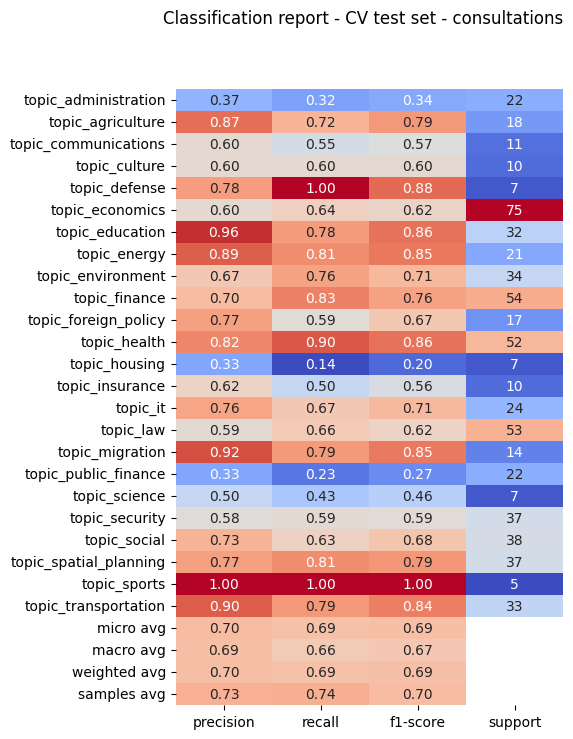

In [31]:
fig = plotting.plot_classification_report_heatmap(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV test set - consultations")
mlflow.log_figure(fig, "classification_report_heatmap_cv_test.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


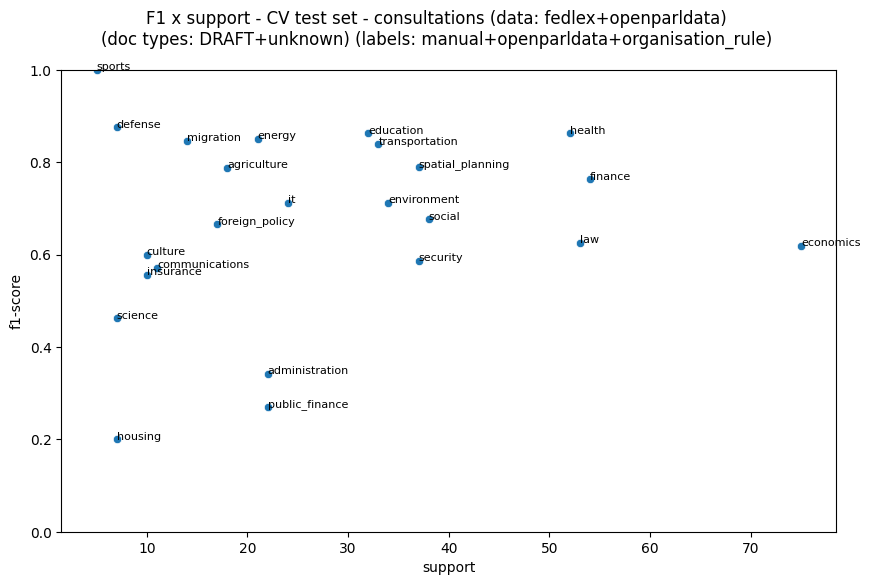

In [32]:
fig = plotting.plot_score_against_support(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
document_sources = "+".join(sorted(DOCUMENT_SOURCES))
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            f"F1 x support - CV test set - consultations (data: {document_sources})",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
mlflow.log_figure(fig, "classification_report_score_against_support_cv_test.png")
fig

***

## Evaluation on the test set (USE SPARINGLY)

In [33]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, y_test.values
    )
    test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, test_predictions_docs
    )

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)
    print("consultations: ground truth", test_ground_truth_consultations.shape)
    print("consultations: predictions", test_predictions_consultations.shape)

In [34]:
if USE_TEST_SET:
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_consultations,
        test_predictions_consultations,
        average="samples",
    )
    scores_consultations = {
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
    }
    mlflow.log_metrics(scores_consultations)
    print("Per consultation scores:")
    print(f"Precision: {scores_consultations['test_precision']:.4f}")
    print(f"Recall:    {scores_consultations['test_recall']:.4f}")
    print(f"F1:        {scores_consultations['test_f1']:.4f}")

In [35]:
if USE_TEST_SET:
    fig = plotting.plot_classification_report_heatmap(
        test_ground_truth_consultations,
        test_predictions_consultations,
        target_names=topic_columns,
    )
    fig.suptitle("Classification report - test set - consultations")
    mlflow.log_figure(fig, "classification_report_heatmap_test.png")
    display(fig)

***

# End MLflow run

In [36]:
mlflow.end_run()